<a href="https://colab.research.google.com/github/sasansharifipour/Spark_Class/blob/main/train_sheypoor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
file_download_link = "https://drive.google.com/u/0/uc?id=1K2a4mliN8l4aO1S8TWyn29EN25Y4WLlQ&export=download" 
!wget -O data.csv --no-check-certificate "$file_download_link"
!pip install category_encoders
import category_encoders as ce

--2021-05-24 04:26:49--  https://drive.google.com/u/0/uc?id=1K2a4mliN8l4aO1S8TWyn29EN25Y4WLlQ&export=download
Resolving drive.google.com (drive.google.com)... 74.125.201.138, 74.125.201.101, 74.125.201.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.201.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f7kpau96d2ogajkoijugtm6pf7eefira/1621830375000/14577798666193718332/*/1K2a4mliN8l4aO1S8TWyn29EN25Y4WLlQ?e=download [following]
--2021-05-24 04:26:51--  https://doc-0g-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f7kpau96d2ogajkoijugtm6pf7eefira/1621830375000/14577798666193718332/*/1K2a4mliN8l4aO1S8TWyn29EN25Y4WLlQ?e=download
Resolving doc-0g-70-docs.googleusercontent.com (doc-0g-70-docs.googleusercontent.com)... 172.217.212.132, 2607:f8b0:4001:c03::84
Connecting to doc-0g-70-docs.googleusercontent.com (d

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas as pd

data = pd.read_csv('data.csv')

df = pd.DataFrame(data)

encoder=ce.HashingEncoder(cols='source',n_components=1)
encoder.fit_transform(df)

,col_0,Unnamed: 0,userid,time,adstatus,item,count_views
0,1,0,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,۳ روز پیش,A,1
1,1,1,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,۴ روز پیش,A,1
2,1,2,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,۲ روز پیش,B,1
3,1,3,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,۶ روز پیش,B,1
4,1,4,1337524499886/ad464731-6288-4e04-8a1a-aa9c004f...,2021-05-03 05:00:00.000,ساعاتی پیش,A,1
...,...,...,...,...,...,...,...
169510,1,169510,1651749233345/413f5cb9-48ab-41b2-a2f2-55f2e1b0...,2021-05-05 12:00:00.000,۳ روز پیش,C,3
169511,1,169511,1651749233345/413f5cb9-48ab-41b2-a2f2-55f2e1b0...,2021-05-05 18:00:00.000,ساعاتی پیش,C,1
169512,1,169512,1769507823559/b36ec32b-c81b-42c0-80f2-15ca32c2...,2021-05-04 09:00:00.000,ساعاتی پیش,A,1
169513,1,169513,1769507823559/b36ec32b-c81b-42c0-80f2-15ca32c2...,2021-05-04 09:00:00.000,۴ هفته پیش,A,1


In [89]:
import pandas as pd
import keras
from keras import layers

class onehot_autoencoder:
  def __init__(self, features, num_of_epochs):
    self.features = features
    self.num_of_epochs = num_of_epochs
    self.encoders = []
  
  def create_auto_encoder(self, input_dim, encoding_dim):
    
    input_layer = keras.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='sigmoid')(input_layer)
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
    
    autoencoder = keras.Model(input_layer, decoded)
    encoder = keras.Model(input_layer, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder, encoder


  def fit_transform(self, data):
    self.data = data
    self.features_list = [item[0] for item in self.features]
    result_df = pd.DataFrame()

    for column_name in self.data.columns:
      if (column_name not in self.features_list):
        if result_df.empty:
          feature_df = pd.DataFrame(data=self.data[column_name], columns=[column_name])
          result_df = feature_df
        else:
          feature_df = pd.DataFrame(data=self.data[column_name], columns=[column_name])
          result_df = result_df.join(feature_df)

    for (feature_name, feature_cnt) in self.features:

      df = pd.get_dummies(data[feature_name], prefix=feature_name)
      autoencoder, encoder = self.create_auto_encoder(len(df.columns), feature_cnt)
      autoencoder.fit(df, df, epochs = self.num_of_epochs, batch_size=256, shuffle=True, verbose=0)
      y = encoder.predict(df)
      self.encoders.append(encoder)

      columns_name = []
      for i in range(feature_cnt):
        columns_name.append(feature_name + '_' + str(i))

      if result_df.empty:
        feature_df = pd.DataFrame(data=y, columns=columns_name)
        result_df = feature_df
      else:
        feature_df = pd.DataFrame(data=y, columns=columns_name)
        result_df = result_df.join(feature_df)

    return result_df
      

In [90]:
encoder = onehot_autoencoder([ ('source', 1), ('item', 2), ('adstatus', 5)], 10)
m = encoder.fit_transform(df)
m.head()

,Unnamed: 0,userid,time,count_views,source_0,item_0,item_1,adstatus_0,adstatus_1,adstatus_2,adstatus_3,adstatus_4
0,0,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,1,0.973893,0.984368,0.984554,0.976239,0.168279,0.064292,0.934817,0.908366
1,1,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,1,0.973893,0.984368,0.984554,0.328151,0.941897,0.037714,0.848275,0.953353
2,2,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,1,0.015706,0.484772,0.018919,0.121906,0.031287,0.970511,0.978653,0.975000
3,3,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,1,0.015706,0.484772,0.018919,0.969390,0.400329,0.340642,0.044148,0.151577
4,4,1337524499886/ad464731-6288-4e04-8a1a-aa9c004f...,2021-05-03 05:00:00.000,1,0.015706,0.984368,0.984554,0.571701,0.981148,0.956385,0.044050,0.975405


In [69]:
m.count()

Series([], dtype: int64)

In [ ]:
df.head()

,Unnamed: 0,userid,time,source,adstatus,item,count_views
0,0,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,Chrome,۳ روز پیش,A,1
1,1,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,Chrome,۴ روز پیش,A,1
2,2,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,Android,۲ روز پیش,B,1
3,3,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,Android,۶ روز پیش,B,1
4,4,1337524499886/ad464731-6288-4e04-8a1a-aa9c004f...,2021-05-03 05:00:00.000,Android,ساعاتی پیش,A,1


In [ ]:
import networkx as nx

def create_graph(data):
  graph = nx.Graph()

  for index, row in data.iterrows():
    source_node = row["userid"]
    destination_node = str(row["adstatus"])
    item_destination_node = str(row["item"])
    source_destination_node = str(row["source"])

    prior_weight = row["count_views"]

    graph.add_node(source_node, node_type='user')
    graph.add_node(destination_node, node_type='adstatus')
    graph.add_node(item_destination_node, node_type='item')
    graph.add_node(source_destination_node, node_type='source')

    node_attributes = graph.get_edge_data(source_node, destination_node)

    if (node_attributes is not None):
      prior_weight = prior_weight + node_attributes["weight"]

    prior_weight = 1;
    graph.add_weighted_edges_from([
                                   (source_node, destination_node, prior_weight),
                                   (source_node, item_destination_node, prior_weight),
                                   (source_node, source_destination_node, prior_weight),
                                   (destination_node, item_destination_node, prior_weight)
                                   ])

  return graph


graph = create_graph(df)

In [ ]:
#page_ranks = nx.pagerank(graph, weight ='weight', max_iter =1000, alpha=0.85)
page_ranks = nx.pagerank(graph, max_iter =1000, alpha=0.85)

In [ ]:
user_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "user"})
item_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "item"})
page_ranks.get(user_nodes[0])

8.144699724519055e-06

In [ ]:
min(page_ranks.values())

7.902686161329932e-06

In [ ]:
def extract_features(graph, page_ranks):
  user_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "user"})
  item_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "item"})
  adstatus_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "adstatus"})
  source_nodes = list({n for n, d in graph.nodes(data=True) if d["node_type"] == "source"})

  column_names = []
  column_names.extend(item_nodes.copy())
  column_names.extend(adstatus_nodes.copy())
  column_names.extend(source_nodes.copy())
  column_names.insert(0, 'user_rank')
  column_names.insert(0, 'user_id')

  data = []

  for user in user_nodes :
    user_rank = page_ranks.get(user)
    row_data = [user, user_rank]

    for item in item_nodes :
      item_rank = page_ranks.get(item)

      node_weight = 0
      node_attributes = graph.get_edge_data(user, item)
      
      if (node_attributes is not None):
        node_weight = node_attributes["weight"]
        
      calculated_feature = node_weight * user_rank * item_rank
      row_data.append(calculated_feature)
    
    for item in adstatus_nodes :
      item_rank = page_ranks.get(item)

      node_weight = 0
      node_attributes = graph.get_edge_data(user, item)
      
      if (node_attributes is not None):
        node_weight = node_attributes["weight"]
        
      calculated_feature = node_weight * user_rank * item_rank
      row_data.append(calculated_feature)

    for item in source_nodes :
      item_rank = page_ranks.get(item)

      node_weight = 0
      node_attributes = graph.get_edge_data(user, item)
      
      if (node_attributes is not None):
        node_weight = node_attributes["weight"]
        
      calculated_feature = 1 * user_rank * item_rank
      row_data.append(calculated_feature)

    data.append(row_data)
  
  df = pd.DataFrame(data, columns = column_names)
  return df

In [ ]:
df_features = extract_features(graph, page_ranks)

In [ ]:
df_features.head(10)

,user_id,user_rank,A,B,C,ساعاتی پیش,۱ سال پیش,۱ روز پیش,۱ هفته پیش,۵ ماه پیش,۲ روز پیش,۱۰ ماه پیش,۲ هفته پیش,دقایقی پیش,لحظاتی پیش,۴ روز پیش,۳ ماه پیش,۵ روز پیش,۳ روز پیش,۸ ماه پیش,۷ ماه پیش,۱۱ ماه پیش,۶ روز پیش,۱ ماه پیش,۴ هفته پیش,۲ ماه پیش,۳ هفته پیش,۴ ماه پیش,۹ ماه پیش,۶ ماه پیش,Android,Chrome
0,1616044255144/74abc9fe-3abd-4f8b-a48d-7165fc44...,0.000008,5.399870e-07,0.000000e+00,0.000000e+00,4.726908e-07,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,7.732854e-09,9.265459e-07
1,1616439213041/6ccb934d-70f3-4ae7-a0ef-2e7b0c5c...,0.000008,5.399870e-07,0.000000e+00,0.000000e+00,4.726908e-07,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,7.732854e-09,9.265459e-07
2,1616766530803/b35221a5-243b-402e-be40-f882d141...,0.000011,7.488753e-07,0.000000e+00,0.000000e+00,6.555464e-07,0.0,2.889739e-07,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.423924e-07,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1.072423e-08,1.284970e-06
3,1618468173263/6a55ba83-55a5-4854-bb19-8a243dd7...,0.000008,0.000000e+00,0.000000e+00,1.002933e-07,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.474000e-07,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,7.699713e-09,9.225749e-07
4,1619597237452/7f06cd64-59b2-4674-99f5-81fe3734...,0.000016,1.057778e-06,0.000000e+00,0.000000e+00,9.259521e-07,0.0,0.000000e+00,3.526434e-07,0.0,2.690650e-07,0.0,2.459444e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,2.011277e-07,0.0,0.0,0.0,1.220254e-07,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1.514786e-08,1.815007e-06
5,1618762640624/14ec0ad3-90f0-43f6-b8ff-94f6163c...,0.000026,1.691668e-06,0.000000e+00,0.000000e+00,1.480843e-06,0.0,6.527761e-07,5.639703e-07,0.0,4.303064e-07,0.0,3.933303e-07,4.692156e-07,4.637613e-07,2.665401e-07,0.0,2.272711e-07,3.216565e-07,0.0,0.0,0.0,1.951509e-07,0.0,0.0,0.0,3.134807e-07,0.0,0.0,0.0,2.422544e-08,2.902677e-06
6,1620177074096/d5eb5af7-0831-4c4a-bfc1-c28501fd...,0.000008,5.399870e-07,0.000000e+00,0.000000e+00,4.726908e-07,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,7.732854e-09,9.265459e-07
7,1619946446310/0f19f07e-6327-430b-bcde-db0805da...,0.000008,0.000000e+00,3.310678e-07,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,1.250171e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,7.699876e-09,9.225945e-07
8,1615054190354/cc4b2ef9-3499-4e92-9c53-84d7d5a2...,0.000008,0.000000e+00,3.287336e-07,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,8.412050e-08,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,7.645590e-09,9.160899e-07
9,1620149991553/6b200a01-2b30-4ce3-a519-c56898d2...,0.000008,0.000000e+00,3.369287e-07,0.000000e+00,4.790074e-07,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,7.836188e-09,9.389273e-07


In [ ]:
from sklearn import preprocessing

df_without_user_id = df_features.iloc[:, 1::].to_numpy()

min_max_scaler = preprocessing.MinMaxScaler()
df_without_user_id_scaled = min_max_scaler.fit_transform(df_without_user_id)

df_scaled = pd.DataFrame(df_without_user_id_scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0.008704,0.250468,0.0,0.000000,0.228103,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008704,0.008704
1,0.008704,0.250468,0.0,0.000000,0.228103,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008704,0.008704
2,0.122024,0.347359,0.0,0.000000,0.316343,0.0,0.316343,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.316343,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122024,0.122024
3,0.007449,0.000000,0.0,0.227126,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.227126,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007449,0.007449
4,0.289601,0.490640,0.0,0.000000,0.446831,0.0,0.000000,0.446831,0.0,0.446831,0.0,0.446831,0.0,0.000000,0.0,0.0,0.0,0.446831,0.0,0.0,0.0,0.446831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.289601,0.289601


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)

pca.fit(df_without_user_id_scaled)
pca_data = pca.transform(df_without_user_id_scaled)

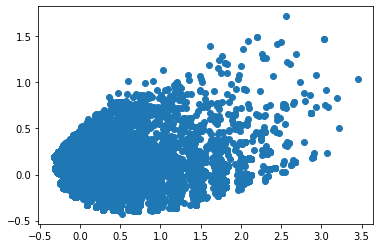

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(pca_data[:,0], pca_data[:,1])
plt.show()

In [ ]:
from sklearn.cluster import KMeans
num_clusters = 10

kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=0).fit(pca_data)

In [ ]:
lst = list(kmeans.labels_)
for i in range(num_clusters):
  print(str(i) + ":" + str(lst.count(i)))

0:13871
1:1446
2:4317
3:9511
4:884
5:1350
6:9684
7:3136
8:5732
9:1986


In [ ]:
df["adstatus"].value_counts()

ساعاتی پیش    48208
۱ روز پیش     18756
۱ هفته پیش    15165
دقایقی پیش    13422
لحظاتی پیش    12156
۲ روز پیش     11864
۲ هفته پیش    10335
۳ روز پیش      8621
۳ هفته پیش     7908
۴ روز پیش      6951
۵ روز پیش      5864
۶ روز پیش      4939
۴ هفته پیش     2446
۱ ماه پیش      1104
۲ ماه پیش       688
۷ ماه پیش       264
۳ ماه پیش       232
۴ ماه پیش       202
۱ سال پیش       172
۵ ماه پیش        84
۶ ماه پیش        38
۱۱ ماه پیش       25
۱۰ ماه پیش       24
۸ ماه پیش        24
۹ ماه پیش        23
Name: adstatus, dtype: int64

In [ ]:
pd.get_dummies(df, columns=["item","adstatus", "source"]).head()

,Unnamed: 0,userid,time,count_views,item_A,item_B,item_C,adstatus_دقایقی پیش,adstatus_ساعاتی پیش,adstatus_لحظاتی پیش,adstatus_۱ روز پیش,adstatus_۱ سال پیش,adstatus_۱ ماه پیش,adstatus_۱ هفته پیش,adstatus_۱۰ ماه پیش,adstatus_۱۱ ماه پیش,adstatus_۲ روز پیش,adstatus_۲ ماه پیش,adstatus_۲ هفته پیش,adstatus_۳ روز پیش,adstatus_۳ ماه پیش,adstatus_۳ هفته پیش,adstatus_۴ روز پیش,adstatus_۴ ماه پیش,adstatus_۴ هفته پیش,adstatus_۵ روز پیش,adstatus_۵ ماه پیش,adstatus_۶ روز پیش,adstatus_۶ ماه پیش,adstatus_۷ ماه پیش,adstatus_۸ ماه پیش,adstatus_۹ ماه پیش,source_Android,source_Chrome
0,0,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,1274821301586/54e79450-bbee-4770-9e47-1d56e120...,2021-05-05 18:00:00.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,2,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,1325384907441/5e5766d8-46cb-480d-886a-7d557542...,2021-05-01 10:00:00.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,4,1337524499886/ad464731-6288-4e04-8a1a-aa9c004f...,2021-05-03 05:00:00.000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
